In [1]:
import numpy as np
from tabpfn import TabPFNRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, 
                                           ExpSineSquared, ConstantKernel)
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from itertools import combinations

In [2]:
from matplotlib import rcParams
# rcParams['font.family'] = 'arial'
rcParams['mathtext.fontset'] = 'dejavuserif'
# rcParams['mathtext.rm'] = 'arial'
# rcParams['mathtext.it'] = 'arial:italic'
# rcParams['mathtext.bf'] = 'arial:bold'
rcParams['axes.titlepad'] = 12
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 25
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [7.8, 5.8]
rcParams['figure.titlesize'] = 25
rcParams['font.size'] = 20.0
rcParams['legend.fontsize'] = 20
# rcParams['legend.frameon'] = False
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17

## How TabPFN extrapolate in 1D?

In [3]:
def linear(x):
    return x

def quadratic(x):
    return  x**2

def step(x):
    return np.array([-1 if t<0 else 1 for t in x])

# def piecewise_linear(x):
#     """
#     Create piecewise linear function connecting specified points
    
#     Parameters:
#     x : array-like - Input values
#     breakpoints : list - x-coordinates of breakpoints (must include 0 and 1)
#     values : list - y-values at breakpoints
#     """
#     breakpoints = [-1, -0.6, 0.2, 0.6, 1]
#     values = [0, 1, -0.5, 0.7, 0]
#     breakpoints = np.array(breakpoints)
#     values = np.array(values)
#     return np.interp(x, breakpoints, values)
def piecewise_linear(x):
    """
    Create piecewise linear function connecting specified points
    
    Parameters:
    x : array-like - Input values
    breakpoints : list - x-coordinates of breakpoints (must include 0 and 1)
    values : list - y-values at breakpoints
    """
    return np.sin(1/x)

/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.

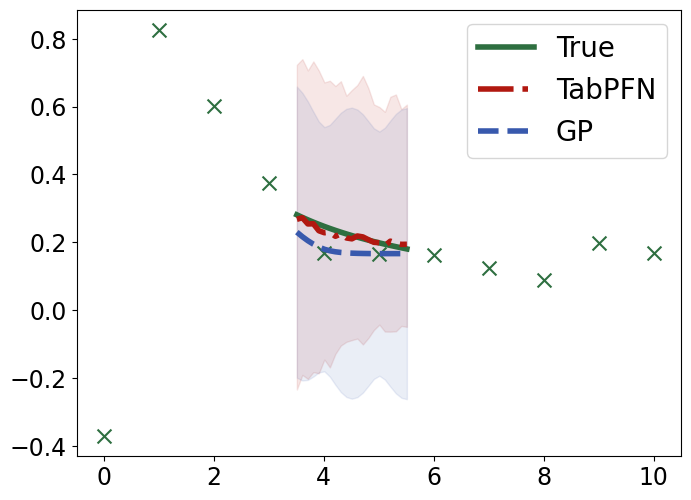

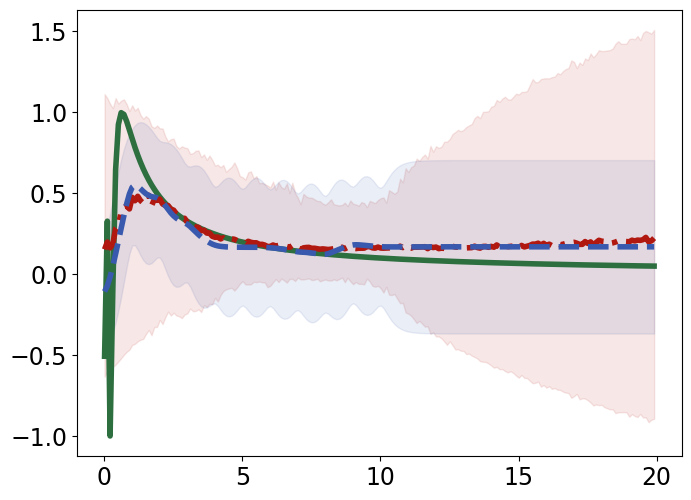

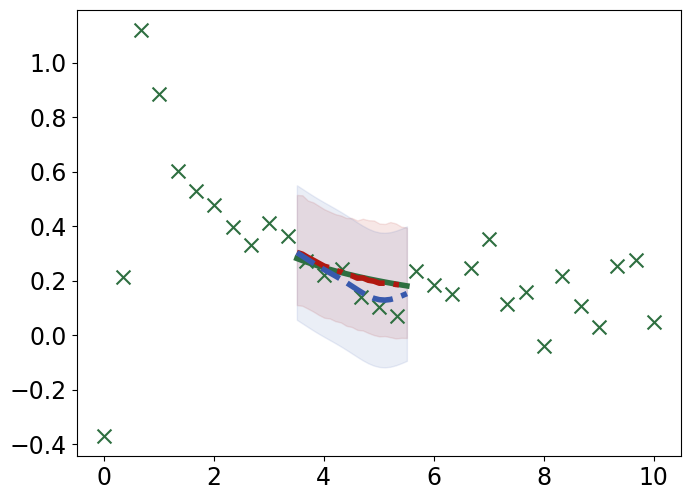

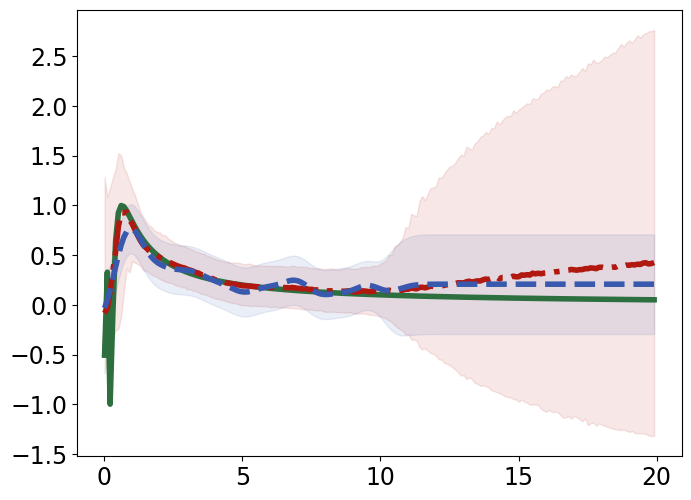

In [7]:
# # fname = ["linear", "quadratic", "step", "piecewiselinear"]
# fname = [ "piecewiselinear"]

# for n in [11, 31]:
# # for n in 11:
#     for i, f in enumerate([piecewise_linear]):
#         X_train = np.linspace(0.01,10, n)
#         np.random.seed(20250419)
#         epsilon = 0.1 *np.random.randn(n)
    
#         y_train = f(X_train) + epsilon
    
    
#         # TabPFN
#         regressor = TabPFNRegressor(model_path = "/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
#         regressor.fit(X_train.reshape((-1,1)), y_train)
#         X_test = np.arange(0.01, 20, 0.1)
#         y_pred = regressor.predict(X_test.reshape((-1,1)),output_type="full",quantiles=[0.025,0.975])
        
         
#         # Define multiple kernel candidates
#         kernel_candidates = [
#             ConstantKernel() * RBF(),
#             ConstantKernel() * Matern(nu=1.5),
#             ConstantKernel() * RationalQuadratic(),
#             ConstantKernel() * ExpSineSquared(),
#             ConstantKernel() * RBF() + ConstantKernel() * Matern()
#         ]
#         alpha_candidates = [0.05, 0.1, 0.15, 0.2]
#         # alpha_candidates = [0.00]
        
#         best_score = -np.inf
#         best_gpr = None
        
#         for kernel in kernel_candidates:
#             for alpha in alpha_candidates:
#                 gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha**2, n_restarts_optimizer=10)
#                 gpr.fit(X_train.reshape((-1,1)), y_train)
#                 score = gpr.log_marginal_likelihood()
#                 # print(alpha, score)
                
#                 if score > best_score:
#                     best_score = score
#                     best_gpr = gpr
#                     best_alpha = alpha
        
#         y_pred_gp, y_cov_gp = gpr.predict(X_test.reshape((-1,1)), return_cov=True)


#         # Interpolation
#         fig = plt.figure()
#         plt.plot(X_test[35:56], f(X_test[35:56]), linewidth=4, color="#2E6F40", label="True")
#         plt.plot(X_test[35:56], y_pred['mean'][35:56], "-.", linewidth=4, color="#b11810", label="TabPFN")
#         plt.fill_between(X_test[35:56], y_pred['quantiles'][0][35:56], y_pred['quantiles'][1][35:56],color="#b11810",alpha=0.1)
#         plt.plot(X_test[35:56], y_pred_gp[35:56], "--", linewidth=4, color="#3859ad", label="GP")
#         plt.fill_between(X_test[35:56], y_pred_gp[35:56] - 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[35:56], y_pred_gp[35:56] + 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[35:56], color="#3859ad", alpha=0.1)
#         plt.scatter(X_train, y_train, s=100, marker="x", color="#2E6F40")
#         if n == 11 and i==0:
#             plt.legend()            
#         plt.savefig("figure/interpolation_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')

#         # Extrapolation
#         fig = plt.figure()
#         plt.plot(X_test, f(X_test), linewidth=4, color="#2E6F40", label="True")
#         plt.plot(X_test, y_pred['mean'], "-.", linewidth=4, color="#b11810", label="TabPFN")
#         plt.fill_between(X_test, y_pred['quantiles'][0], y_pred['quantiles'][1],color="#b11810",alpha=0.1)
#         plt.plot(X_test, y_pred_gp, "--", linewidth=4, color="#3859ad", label="GP")
#         plt.fill_between(X_test, y_pred_gp - 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2), y_pred_gp + 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2), color="#3859ad", alpha=0.1)
#         # plt.scatter(X_train, y_train, s=100, marker="x", color="#2E6F40")
#         # if n == 11 and i==0:
#         #     plt.legend()            
#         plt.savefig("figure/extrapolation_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')


/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


38


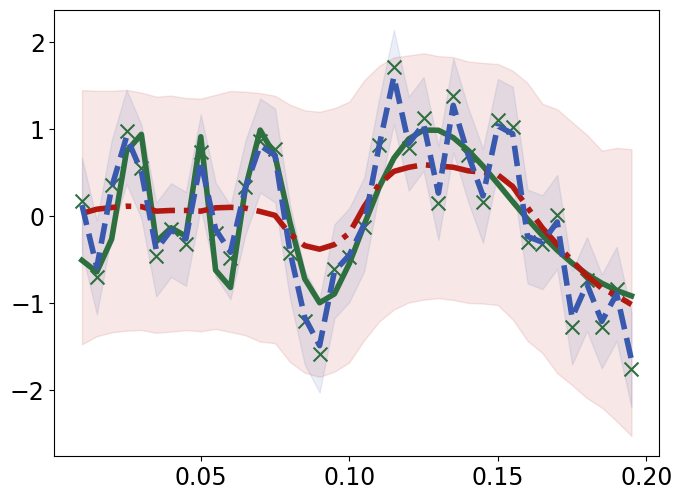

In [21]:
# fname = ["linear", "quadratic", "step", "piecewiselinear"]
fname = [ "piecewiselinear"]

# for n in [11, 31]:
# for n in 11:
step_size = 0.005
for i, f in enumerate([piecewise_linear]):
    X_train = np.arange(0.01, 0.2, step_size)
    np.random.seed(20250419)
    n = X_train.shape[0]
    epsilon = 0.5 *np.random.randn(X_train.shape[0])

    y_train = f(X_train) + epsilon


    # TabPFN
    regressor = TabPFNRegressor(model_path = "/root/autodl-tmp/pfn/tabpfn-v2-regressor.ckpt")
    regressor.fit(X_train.reshape((-1,1)), y_train)
    X_test = X_train
    y_pred = regressor.predict(X_test.reshape((-1,1)),output_type="full",quantiles=[0.025,0.975])
    
     
    # Define multiple kernel candidates
    kernel_candidates = [
        ConstantKernel() * RBF(),
        ConstantKernel() * Matern(nu=1.5),
        ConstantKernel() * RationalQuadratic(),
        ConstantKernel() * ExpSineSquared(),
        ConstantKernel() * RBF() + ConstantKernel() * Matern()
    ]
    alpha_candidates = [0.05, 0.1, 0.15, 0.2]
    # alpha_candidates = [0.00]
    
    best_score = -np.inf
    best_gpr = None
    
    for kernel in kernel_candidates:
        for alpha in alpha_candidates:
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha**2, n_restarts_optimizer=10)
            gpr.fit(X_train.reshape((-1,1)), y_train)
            score = gpr.log_marginal_likelihood()
            # print(alpha, score)
            
            if score > best_score:
                best_score = score
                best_gpr = gpr
                best_alpha = alpha
    
    y_pred_gp, y_cov_gp = gpr.predict(X_test.reshape((-1,1)), return_cov=True)


    # Interpolation
    fig = plt.figure()
    print(n)
    plt.plot(X_test[:n], f(X_test[:n]), linewidth=4, color="#2E6F40", label="True")
    plt.plot(X_test[:n], y_pred['mean'][:n], "-.", linewidth=4, color="#b11810", label="TabPFN")
    plt.fill_between(X_test[:n], y_pred['quantiles'][0][:n], y_pred['quantiles'][1][:n],color="#b11810",alpha=0.1)
    plt.plot(X_test[:n], y_pred_gp[:n], "--", linewidth=4, color="#3859ad", label="GP")
    plt.fill_between(X_test[:n], y_pred_gp[:n] - 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[:n], y_pred_gp[:n] + 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[:n], color="#3859ad", alpha=0.1)
    plt.scatter(X_train, y_train, s=100, marker="x", color="#2E6F40")
    # if n == 11 and i==0:
    #     plt.legend()            
    plt.savefig("figure/interpolation_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')

    # # Extrapolation
    # fig = plt.figure()
    # plt.plot(X_test, f(X_test), linewidth=4, color="#2E6F40", label="True")
    # plt.plot(X_test, y_pred['mean'], "-.", linewidth=4, color="#b11810", label="TabPFN")
    # plt.fill_between(X_test, y_pred['quantiles'][0], y_pred['quantiles'][1],color="#b11810",alpha=0.1)
    # plt.plot(X_test, y_pred_gp, "--", linewidth=4, color="#3859ad", label="GP")
    # plt.fill_between(X_test, y_pred_gp - 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2), y_pred_gp + 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2), color="#3859ad", alpha=0.1)
    # # plt.scatter(X_train, y_train, s=100, marker="x", color="#2E6F40")
    # # if n == 11 and i==0:
    # #     plt.legend()            
    # plt.savefig("figure/extrapolation_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')


38


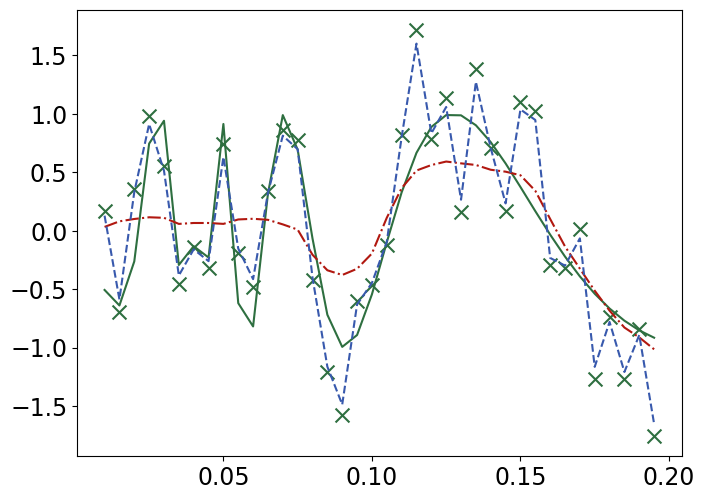

In [22]:
fig = plt.figure()
print(n)
plt.plot(X_test[:n], f(X_test[:n]), color="#2E6F40", label="True")
plt.plot(X_test[:n], y_pred['mean'][:n], "-.", color="#b11810", label="TabPFN")
# plt.fill_between(X_test[:n], y_pred['quantiles'][0][:n], y_pred['quantiles'][1][:n],color="#b11810",alpha=0.1)
plt.plot(X_test[:n], y_pred_gp[:n], "--", color="#3859ad", label="GP")
# plt.fill_between(X_test[:n], y_pred_gp[:n] - 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[:n], y_pred_gp[:n] + 1.96 * np.sqrt(np.diag(y_cov_gp)+best_alpha**2)[:n], color="#3859ad", alpha=0.1)
plt.scatter(X_train, y_train, s=100, marker="x", color="#2E6F40")
# if n == 11 and i==0:
#     plt.legend()            
# plt.savefig("figure/interpolation_model_" + str(fname[i]) + "_n_" + str(n) + ".png", bbox_inches='tight')